# Creating and visualization a climate model

Our goal is to create five things:

- Function to clean data
- Function to predict temperature at specific dates in future
- Function to get correlation
- Function all of these factors into a single beautiful visualization

In [433]:
# first we have to import the necessary libraries
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline

In [214]:
# next we need to read in the data
df = pd.read_csv("data/glt.csv")

In [215]:
# lets look at the top rows in the data
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


# Function to clean data

In [260]:
# lets create a function to clean the data (will only work on this dataset)

# first we define the function *clean* and set the arguments it should accept
# in this case those are the data, the country we want to segment, and the year we want to segment from
def clean(data, country, from_year):
    
    # setting the data equal to only the data from the country we are interested in
    df = data[data['Country'] == country]

    # converting the index to a datetime type
    df['dt'] = pd.to_datetime(df['dt'])
    
    # segmenting data specifically from the years we are interested in
    # we remove 5 years because later 5 years will be subtracted after SMA is applied
    df = df[df['dt'] > pd.to_datetime("01-01-{}".format(from_year))]
    
    # dropping the state and averagetemperatureuncertainty, as for our purposes here that is not useful
    df.drop(['State','AverageTemperatureUncertainty'],inplace=True,axis=1)
    
    # renaming df to date because that is nicer
    df.columns = ['date','mean_yearly_temp','country']
    
    # getting the years we need
    lst = []
    for i in df['date']:
        lst.append(int(float(str(i)[:4])))
    
    # setting the date column to the years
    df['year'] = lst
    
    # grouping the data by the day, looking at the mean temp of each year
    df = df.groupby('year').mean()

    
    # dropping all na values
    df.dropna(inplace=True)
    
    # adding year as a column instead of index
    df.reset_index(inplace=True)
    
    # returning the dataframe
    return df
    


In [261]:
# testing the cleaning function on our data

us = clean(df,'United States',1900)
russia = clean(df,'Russia',1900)
india = clean(df,'India',1900)
china = clean(df,'China',1900)
canada = clean(df,'Canada',1900)
brazil = clean(df,'Brazil',1900)
australia = clean(df,'Australia',1900)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [415]:
russia.head()

,year,mean_yearly_temp
0,1900,2.532435
1,1901,1.625792
2,1902,0.141283
3,1903,1.721499
4,1904,1.055635


# Function to get correlation

In [263]:
# simply using pandas corr method and indexing the proper correlation with iloc
# also rounding to 2 decimal points
def get_correlation(data):
    c = data.corr().iloc[0].iloc[1]
    return round(c,2)

# Function to predict temperature at specific dates in the future

In order to do this we just need to find the slope and y intercept of the linear regression line

I used slightly modified code from these tutorials:

https://pythonprogramming.net/how-to-program-best-fit-line-slope-machine-learning-tutorial/

https://pythonprogramming.net/how-to-program-best-fit-line-machine-learning-tutorial/?completed=/how-to-program-best-fit-line-slope-machine-learning-tutorial/

In [318]:
def slope_intercept(data):
    x = data['year']
    y = data['mean_yearly_temp']
    slope = (((mean(x)*mean(y)) - mean(x*y)) /  ((mean(x)*mean(x)) - mean(x*x)))
    intercept = mean(y) - slope*mean(x)
    return slope, intercept

In [319]:
# to understand how this works - reference the tutorials above

def get_prediction(data,year):
    x = data['year']
    y = data['mean_yearly_temp']
    predict_x = year
    slope, intercept = slope_intercept(data)
    predict_y = (slope*predict_x)+intercept
    return predict_y

In [299]:
# testing
print("How much hotter will the different countries be (on average) 100 years from now?")
print("")
print("Australia: {}".format(get_prediction(australia,2119) - get_prediction(australia,2019)))
print("United States: {}".format(get_prediction(us,2119) - get_prediction(us,2019)))
print("Russia: {}".format(get_prediction(russia,2119) - get_prediction(russia,2019)))
print("India: {}".format(get_prediction(india,2119) - get_prediction(india,2019)))
print("Canada: {}".format(get_prediction(canada,2119) - get_prediction(canada,2019)))
print("Brazil: {}".format(get_prediction(brazil,2119) - get_prediction(brazil,2019)))
print("China: {}".format(get_prediction(china,2119) - get_prediction(china,2019)))
print("")
print("Note that this is a linear model and does not account for exponential growth \nor the positive feedback loops we expect to see as climate change worsens.")

How much hotter will the different countries be (on average) 100 years from now?

Australia: 0.8929493928400376
United States: 0.9349635825276543
Russia: 1.5091439503520654
India: 0.7798343108906778
Canada: 1.3859520488687593
Brazil: 1.0032454168020273
China: 1.0115563616477132

Note that this is a linear model and does not account for exponential growth 
or the positive feedback loops we expect to see as climate change worsens.


# Function to visualize the above information in a nice way

In [423]:
def visualize(data,country,from_year,pred_year):
    data = clean(data,country,from_year)
    pred_temp = get_prediction(data,pred_year)
    slope, intercept = slope_intercept(data)
    new = pd.DataFrame({'year':list(range(int(data['year'][-1:]),pred_year))})
    lin_pred = intercept + slope * new['year']
    new['pred'] = lin_pred
    ax = plt.figure(figsize=(16,8))
    plt.scatter(data['year'],data['mean_yearly_temp'],label='Historical Yearly Average Temperature',alpha=0.9)
    plt.plot(data['year'], intercept + slope * data['year'], '-',label='Historical Regression Line',linewidth=5,alpha=0.7)
    plt.plot(new['year'],new['pred'],'-',c='red',label='Predicted Regression Line',linewidth=5,alpha=0.5)
    plt.scatter(pred_year,pred_temp,color='red',label='Predicted Average Temperature',s=200)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    locs,labels = plt.yticks()

    for i in locs:
        plt.axhline(y=i,linestyle='--',alpha=0.3)

    plt.annotate("{} C".format(round(pred_temp,1)),(pred_year+pred_year*0.0015,pred_temp+pred_temp*-0.0055),fontsize=18,alpha=0.8)

    plt.ylabel("Temperature in Celcius\n",fontsize=18,alpha=0.8)
    plt.xlabel("\nYear",fontsize=16,alpha=0.8)
    plt.title("Average Temperature Prediction for {} by {} using Linear Model\nCorrelation Coefficient: {}\n".format(country,pred_year,get_correlation(data)),fontsize=18,alpha=0.8)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


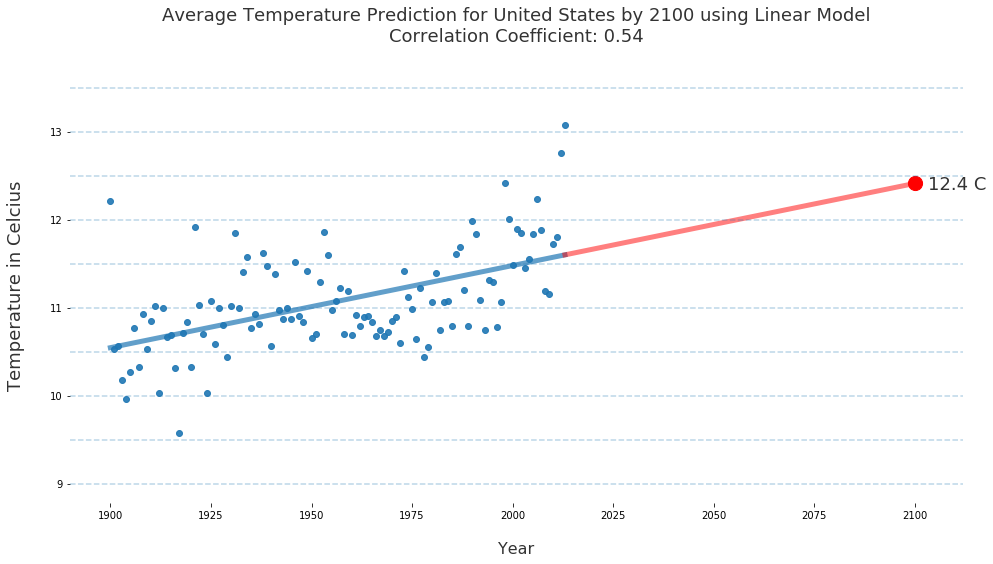

In [426]:
visualize(df,'United States',1900,2100)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


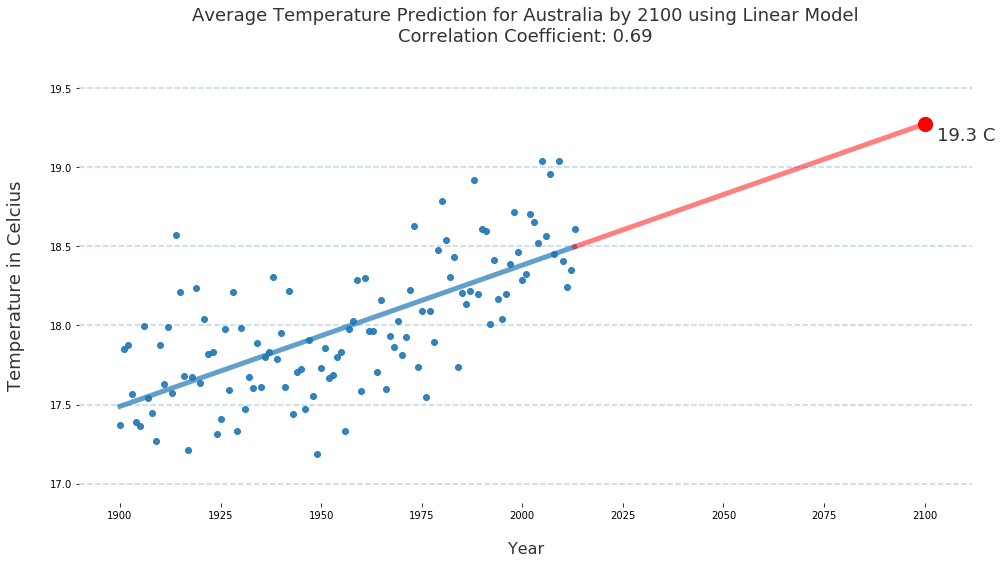

In [428]:
visualize(df,'Australia',1900,2100)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


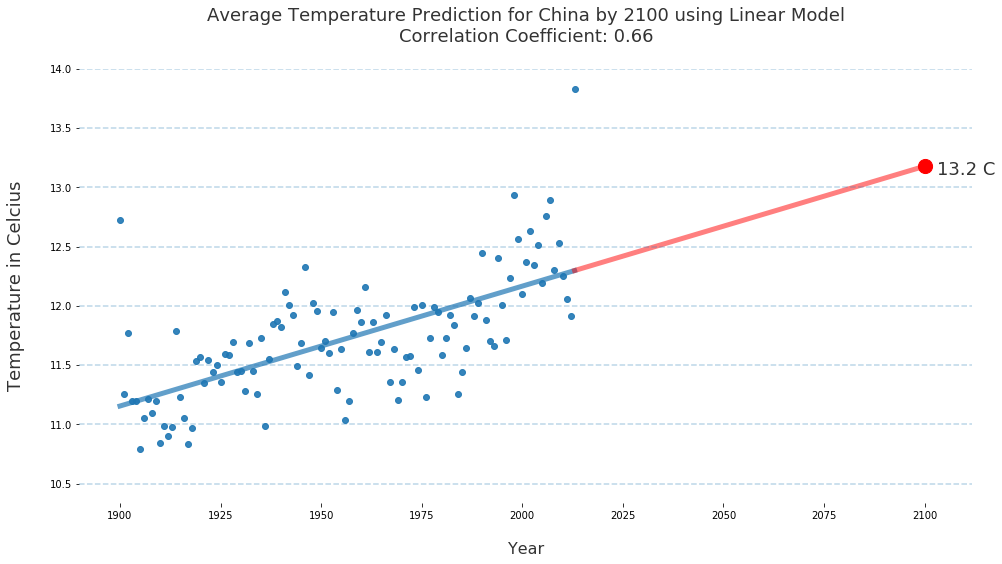

In [429]:
visualize(df,'China',1900,2100)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


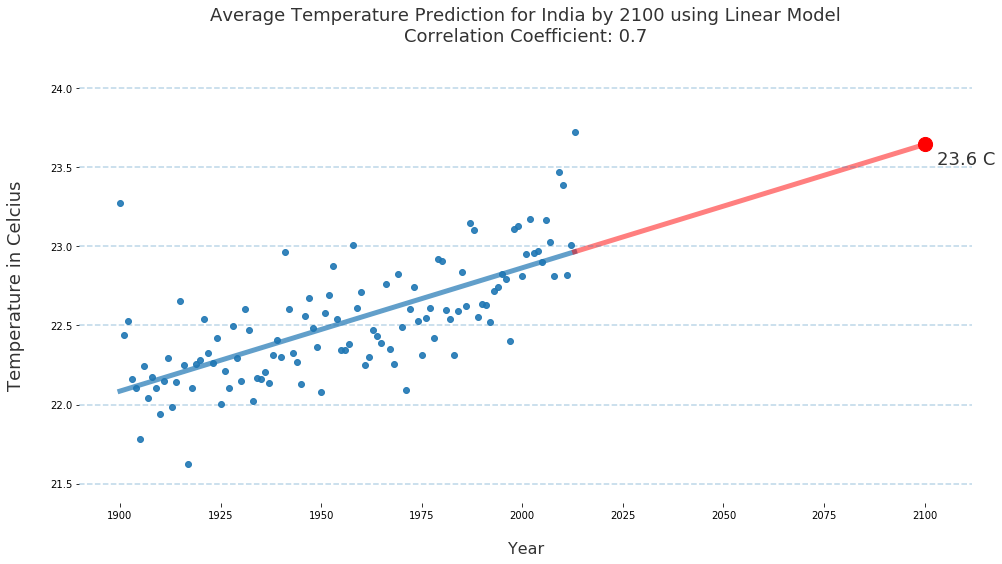

In [430]:
visualize(df,'India',1900,2100)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


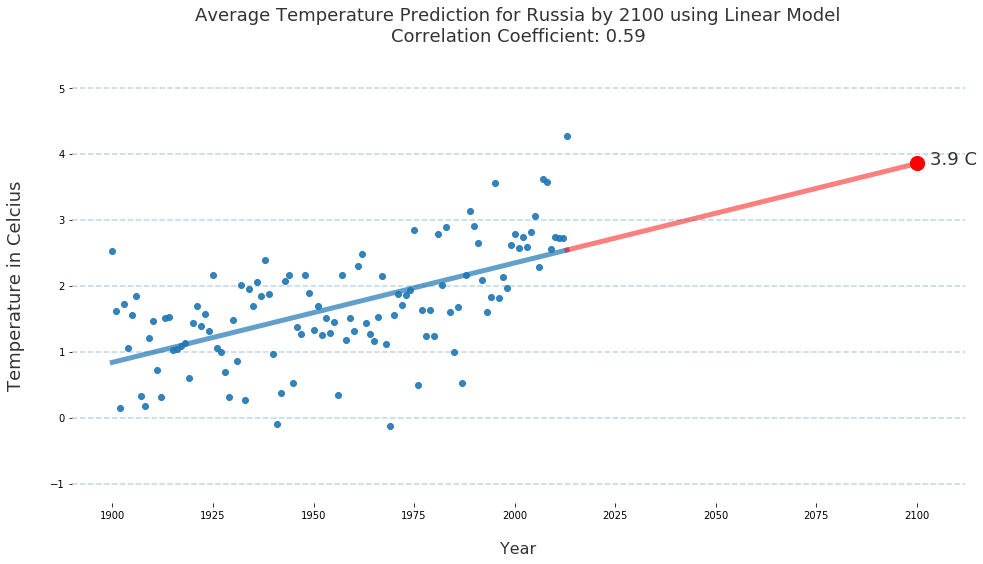

In [431]:
visualize(df,'Russia',1900,2100)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


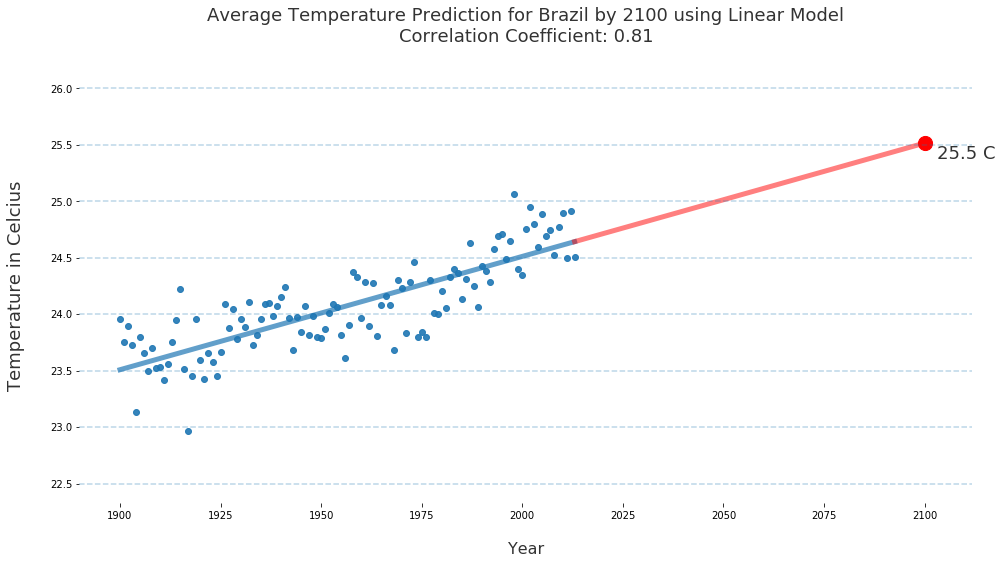

In [434]:
visualize(df,'Brazil',1900,2100)

C:\Users\92YResidence\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


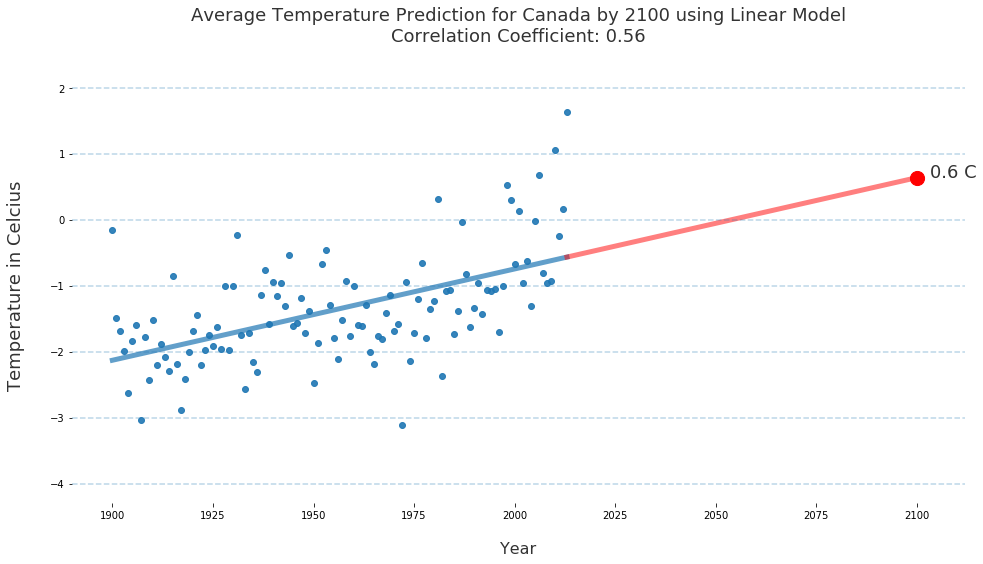

In [435]:
visualize(df,'Canada',1900,2100)